In [4]:
import xarray as xr
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import pandas as pd
import matplotlib.colors as plc 
import xclim.indices as xc
from xclim.indices import warm_and_dry_days
from xclim.indices import warm_and_wet_days
from xclim.core.calendar import percentile_doy
#import pymannkendall as mk
import geopandas as gpd

from xclim.core.units import (
    convert_units_to,
    declare_units,
    ensure_delta,
    pint2cfunits,
    rate2amount,
    str2pint,
    to_agg_units,
)
from xclim.core.calendar import resample_doy
import colormap as zcol

## Colorbar

In [5]:
import sys
sys.path.insert(0,'/home/jovyan/pilot2/zapata/')
import mycolormap as zcol
ss = zcol.make_cmap('3w_bgYr', colpath ='/home/jovyan/pilot2/zapata/SciVis_colormaps/')

Using colormap /home/jovyan/pilot2/zapata/SciVis_colormaps//3w_bgYr.xml


## Path

In [6]:
path= '/home/jovyan/pilot2/data/Vhr-rea_It'
path_era5land='/home/jovyan/pilot2/data/Era5_land'
path_nc= '/home/jovyan/pilot2/Output/netcdf'
path_csv= '/home/jovyan/pilot2/Output/csv'
path_shape= '/home/jovyan/pilot2/Output/shape'
path_mask= '/home/jovyan/pilot2/mask_Torino'
path_map= '/home/jovyan/pilot2/Output/map'

## Comments on the code

In [ ]:
#This notebook presents an example for calculating indicators using the "ERA5-LAND" dataset. 
#The code maintains a structure entirely consistent with the codes employed for computing indicators with the 
#VHR-REA_IT and CERRA datasets (available in this directory) and enables the generation of three output formats 
#through a streamlined process: CSV, shapefile, and PNG.

#Differences from other codes (code_indicators_Vhr_rea and code_indicators_Cerra):
# -Variable nomenclature in the input files (input files available here: '/home/jovyan/pilot2/data/Era5_land')
# -Spatial mask applied for the Turin territory (mask available here: '/home/jovyan/pilot2/mask_Torino')

#For clarity purposes, all variable names present in the input files and the exact designation of the mask to be 
#utilized in the generation of the various outputs are provided below.

#Mean Temperature= temp_mean
#Maximum Temperature= temp_max
#Minimum Temperature= temp_min
#Precipitation= precip_sum
#Dew Point Temperature= dewpoint_mean

#Mask= mask_torino_era5land2.nc (select the variable "mask_torino_era5land")

#The cells below present, by way of example, the calculation of the climate indicators utilizing the ERA5-LAND dataset.

## Summer Days= Number of days with daily maximum temperature greater than 25°C. 

In [9]:
##DATA
#Loading data: Max. Temperature
data_temp= xr.open_dataset(path_era5land+'/tmax_era5land_1991_2020.nc', engine='netcdf4')
tasmax=data_temp['temp_max']
tasmax_K=tasmax+273.15
tasmax_K.attrs["units"] = "K"

In [14]:
##Evaluation
Su=xc.tx_days_above(tasmax_K, thresh='25 degC', freq='YS')
Su_mean=Su.mean(dim='time')
Su_mean=Su_mean.to_dataset(name='SU')
#Su=Su_mean.to_netcdf('/home/jovyan/pilot2/Output/netcdf/su_era5_land-italy_year_comune_torino_1991-2020.nc')

In [17]:
#CSV
Su_mean=Su.mean(dim= ['latitude','longitude']) 
Su_std=Su.std(dim= ['latitude','longitude'])
df=Su_mean.to_dataframe().reset_index().rename(columns= {'temp_max':'Su[days]'})
df_std=Su_std.to_dataframe().reset_index().rename(columns= {'temp_max':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Su[days]'] = np.round(df['Su[days]'],0)
df.to_csv(path_csv+'/su_era5_land_year_comune_torino_1991-2020.csv',index=False)

In [21]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']

Su_mean= Su.mean(dim='time')
clip_var = msk_me * Su_mean
ds=clip_var.to_dataset(name='Su[d]')
df=ds.to_dataframe().reset_index().dropna().reset_index(drop=True)
df['Su[d]'] = np.round(df['Su[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/su_era5_land_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/opt/conda/lib/python3.11/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


/tmp/ipykernel_1047/1058039616.py:33: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks, label=ticks_label)
/tmp/ipykernel_1047/1058039616.py:34: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.clim(vmin=vmin, vmax=vmax)


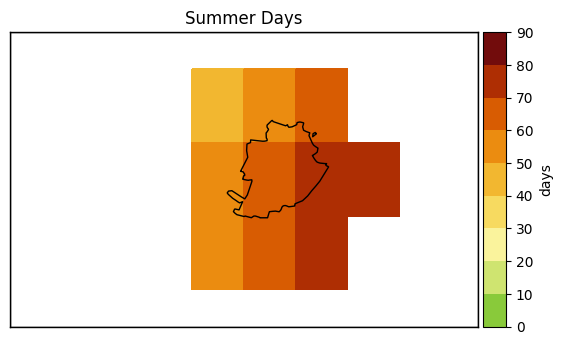

In [24]:
# Map
ds = xr.open_dataset(path_nc+'/su_era5_land-italy_year_comune_torino_1991-2020.nc')
Su = np.round((ds['SU']),0)
lon = ds.longitude.values
lat = ds.latitude.values

lon2d, lat2d = np.meshgrid(lon, lat)

vmax = round(np.nanmax(Su),0) 
vmin = 0
ticks = np.round(np.arange(vmin, vmax+5,10),0)
ticks_label = np.round(np.arange(vmin, vmax+5,10),0)
colors = ss(np.linspace(0.6, 0.97, len(ticks)-1))
cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']
clip_var = msk_me * Su

mp = Basemap(projection='merc', llcrnrlon=np.nanmin(lon), llcrnrlat=np.nanmin(lat), 
             urcrnrlon=np.nanmax(lon), urcrnrlat=np.nanmax(lat), resolution='i')
mp.drawmapboundary()

x, y = mp(lon2d, lat2d)

mp.drawcoastlines(linewidth=1)
mp.drawmapboundary()
mp.readshapefile(path_mask+'/torino', 'torino', linewidth=1)

c_scheme = mp.pcolor(x, y, np.squeeze(clip_var[:,:]), cmap=cmap)
cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks, label=ticks_label)
plt.clim(vmin=vmin, vmax=vmax)
cbar.set_label('days')
plt.title('Summer Days')
plt.savefig(path_map+'/su_era5_land_year_comune_torino_1991-2020.png', dpi=300)

## Tropical Nights= Number of days with daily minimum temperature greater than 20°C

In [26]:
##DATA
#Loading data: Max. Temperature
data_temp= xr.open_dataset(path_era5land+'/tmin_era5land_1991_2020.nc', engine='netcdf4')
tasmin=data_temp['temp_min']
tasmin_K=tasmax+273.15
tasmin_K.attrs["units"] = "K"

In [33]:
##Evaluation
Tr= xc.tn_days_above(tasmin_K, thresh='20.0 degC', freq='YS')
Tr_mean=Tr.mean(dim='time')
Tr_mean=Tr_mean.to_dataset(name='TR')
Tr=Tr_mean.to_netcdf(path_nc+'/tr_era5_land-italy_year_comune_torino_1991-2020.nc')

In [29]:
#CSV
Tr_mean=Tr.mean(dim= ['latitude','longitude']) 
Tr_std=Tr.std(dim= ['latitude','longitude'])
df=Tr_mean.to_dataframe().reset_index().rename(columns= {'temp_min':'Tr[days]'})
df_std=Tr_std.to_dataframe().reset_index().rename(columns= {'temp_min':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Tr[days]'] = np.round(df['Tr[days]'],0)
df.to_csv(path_csv+'/tr_era5_land_year_comune_torino_1991-2020.csv',index=False)

In [30]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']

Tr_mean= Tr.mean(dim='time')
clip_var = msk_me * Tr_mean
ds=clip_var.to_dataset(name='Tr[d]')
df=ds.to_dataframe().reset_index().dropna().reset_index(drop=True)
df['Tr[d]'] = np.round(df['Tr[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/tr_era5_land_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/opt/conda/lib/python3.11/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


/tmp/ipykernel_1047/199456860.py:40: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks)


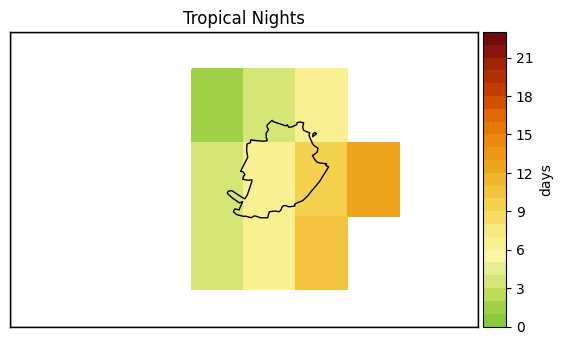

In [57]:
# Map
ds = xr.open_dataset(path_nc+'/tr_era5_land-italy_year_comune_torino_1991-2020.nc')
Tr = np.round((ds['TR']), 0)
lon = ds.longitude.values
lat = ds.latitude.values

# Crea la griglia 2D dalle coordinate
lon2d, lat2d = np.meshgrid(lon, lat)

# Definisci i parametri per la colorbar
vmax = round(np.nanmax(Tr), 0) 
vmin = 0
ticks = np.round(np.arange(vmin, vmax+1, 3), 0)

# Crea la colormap con il numero corretto di colori
n_colors = int(vmax - vmin)   # Un colore per ogni valore intero
colors = ss(np.linspace(0.6, 0.97, n_colors))
cmap = plc.ListedColormap(colors)

# Apri il dataset della maschera
mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']
clip_var = msk_me * Tr

# Crea la mappa
mp = Basemap(projection='merc', llcrnrlon=np.nanmin(lon), llcrnrlat=np.nanmin(lat), 
             urcrnrlon=np.nanmax(lon), urcrnrlat=np.nanmax(lat), resolution='i')
mp.drawmapboundary()

x, y = mp(lon2d, lat2d)

mp.drawcoastlines(linewidth=1)
mp.drawmapboundary()
mp.readshapefile(path_mask+'/torino', 'torino', linewidth=1)

# Plotta i dati
c_scheme = mp.pcolor(x, y, np.squeeze(clip_var[:,:]), cmap=cmap, vmin=vmin, vmax=vmax)

# Crea la colorbar
cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks)
cbar.set_label('days')

plt.title('Tropical Nights')
plt.savefig(path_map+'/tr_era5_land_year_comune_torino_1991-2020.png', dpi=300)

## Hot waves= Number of days with daily maximum temperature greater than 35°C.

In [7]:
##DATA
#Loading data: Max. Temperature
data_temp= xr.open_dataset(path_era5land+'/tmax_era5land_1991_2020.nc', engine='netcdf4')
tasmax=data_temp['temp_max']
tasmax_K=tasmax+273.15
tasmax_K.attrs["units"] = "K"

In [10]:
##Evaluation
Hw=xc.tx_days_above(tasmax_K, thresh='35 degC', freq='YS')
Hw_mean=Hw.mean(dim='time')
Hw_mean=Hw_mean.to_dataset(name='HW')
#Hw=Hw_mean.to_netcdf('/home/jovyan/pilot2/Output/netcdf/hw_era5_land-italy_year_comune_torino_1991-2020.nc')

In [11]:
#CSV
Hw_mean=Hw.mean(dim= ['latitude','longitude']) 
Hw_std=Hw.std(dim= ['latitude','longitude'])
df=Hw_mean.to_dataframe().reset_index().rename(columns= {'temp_max':'Hw[days]'})
df_std=Hw_std.to_dataframe().reset_index().rename(columns= {'temp_max':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Hw[days]'] = np.round(df['Hw[days]'],0)
df.to_csv(path_csv+'/hw_era5_land_year_comune_torino_1991-2020.csv',index=False)

In [12]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']

Hw_mean= Hw.mean(dim='time')
clip_var = msk_me * Hw_mean
ds=clip_var.to_dataset(name='Hw[d]')
df=ds.to_dataframe().reset_index().dropna().reset_index(drop=True)
df['Hw[d]'] = np.round(df['Hw[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/hw_era5_land_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/opt/conda/lib/python3.11/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


/tmp/ipykernel_131/3460477208.py:32: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks, label=ticks_label)
/tmp/ipykernel_131/3460477208.py:33: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.clim(vmin=vmin, vmax=vmax)


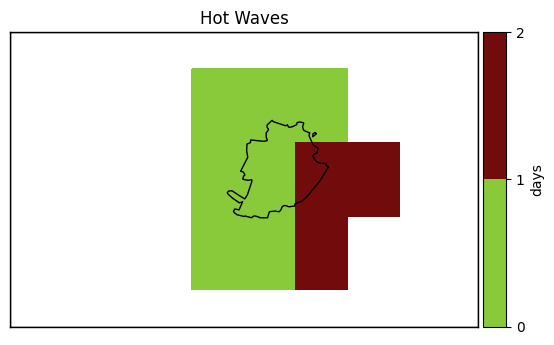

In [17]:
# Map
ds = xr.open_dataset(path_nc+'/hw_era5_land-italy_year_comune_torino_1991-2020.nc')
Hw = np.round((ds['HW']),0)
lon = ds.longitude.values
lat = ds.latitude.values

lon2d, lat2d = np.meshgrid(lon, lat)

vmax = round(np.nanmax(Hw),0) 
vmin = 0
# Cambia il passo da 10 a 5 o un valore più piccolo
ticks = np.round(np.arange(vmin, vmax+1, 1), 0)  # invece di 10
ticks_label = np.round(np.arange(vmin, vmax+1, 1), 0)
colors = ss(np.linspace(0.6, 0.97, len(ticks)-1))
cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']
clip_var = msk_me * Hw

mp = Basemap(projection='merc', llcrnrlon=np.nanmin(lon), llcrnrlat=np.nanmin(lat), 
             urcrnrlon=np.nanmax(lon), urcrnrlat=np.nanmax(lat), resolution='i')
mp.drawmapboundary()

x, y = mp(lon2d, lat2d)

mp.drawcoastlines(linewidth=1)
mp.drawmapboundary()
mp.readshapefile(path_mask+'/torino', 'torino', linewidth=1)

c_scheme = mp.pcolor(x, y, np.squeeze(clip_var[:,:]), cmap=cmap)
cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks, label=ticks_label)
plt.clim(vmin=vmin, vmax=vmax)
cbar.set_label('days')
plt.title('Hot Waves')
plt.savefig(path_map+'/hw_era5_land_year_comune_torino_1991-2020.png', dpi=300)

## Warm Days= Number of days with daily maximum temperature greater than the 90th percentile of daily maximum temperature

In [19]:
#Loading data: Max. Temperature and Percentile
data_temp= xr.open_dataset(path_era5land+'/tmax_era5land_1991_2020.nc', engine='netcdf4')
tasmax=data_temp['temp_max']
tasmax_K=tasmax+273.15
tasmax_K.attrs["units"] = "K"
tasmax_per=percentile_doy(tasmax_K, window=5, per=90).sel(percentiles=90)

In [25]:
##Evaluation
Warm_days=xc.tx90p(tasmax_K,tasmax_per, freq='YS', bootstrap=False)
Warm_days_mean=Warm_days.mean(dim='time')
Warm_days_mean=Warm_days_mean.to_dataset(name='Wd')
#Warm_days=Warm_days_mean.to_netcdf('/home/jovyan/pilot2/Output/netcdf/warm_days_era5_land-italy_year_comune_torino_1991-2020.nc')

In [28]:
#CSV
ds=Warm_days.to_dataset(name='Tx90p[days]')
Tx90p_mean=ds.mean(dim= ['latitude','longitude']) 
Tx90p_std=ds.std(dim= ['latitude','longitude'])
df=Tx90p_mean.to_dataframe().reset_index()#.drop(columns=[ 'heightAboveGround', 'step']) #.rename(columns= {'t2m':'Su[days]'})
df_std=Tx90p_std.to_dataframe().reset_index().rename(columns= {'Tx90p[days]':'Std[days]'})
df['Std[days]'] = np.round(df_std['Std[days]'],0)
df['Tx90p[days]'] = np.round(df['Tx90p[days]'],0)
df.to_csv(path_csv+'/warm_days_era5_land_year_comune_torino_1991-2020.csv',index=False)

In [ ]:
#ShapeFile
mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']

Warm_days_mean=Warm_days.mean(dim='time')
clip_var = msk_me * Warm_days_mean
ds=clip_var.to_dataset(name='Tx90p[d]')
df=ds.to_dataframe().reset_index().dropna().reset_index(drop=True)
df['Tx90p[d]'] = np.round(df['Tx90p[d]'],0)
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
df['geometry'] = geometry
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.to_file(path_shape+'/warm_days_era5_land_year_comune_torino_1991-2020.shp', driver='ESRI Shapefile')

/tmp/ipykernel_131/421435767.py:32: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks, label=ticks_label)
/tmp/ipykernel_131/421435767.py:33: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.clim(vmin=vmin, vmax=vmax)


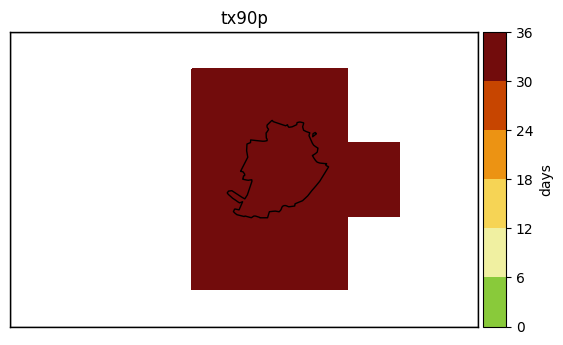

In [39]:
# Map
ds = xr.open_dataset(path_nc+'/warm_days_era5_land-italy_year_comune_torino_1991-2020.nc')
tx90p = np.round((ds['Wd']),0)
lon = ds.longitude.values
lat = ds.latitude.values

lon2d, lat2d = np.meshgrid(lon, lat)

vmax = round(np.nanmax(tx90p),0) 
vmin = 0
# Cambia il passo da 10 a 5 o un valore più piccolo
ticks = np.round(np.arange(vmin, vmax+1, 6), 0)  # invece di 10
ticks_label = np.round(np.arange(vmin, vmax+1, 6), 0)
colors = ss(np.linspace(0.6, 0.97, len(ticks)-1))
cmap = plc.ListedColormap(colors)

mask_ds = xr.open_dataset(path_mask+'/mask_torino_era5land2.nc')
msk_me = mask_ds['mask_torino_era5land']
clip_var = msk_me * tx90p

mp = Basemap(projection='merc', llcrnrlon=np.nanmin(lon), llcrnrlat=np.nanmin(lat), 
             urcrnrlon=np.nanmax(lon), urcrnrlat=np.nanmax(lat), resolution='i')
mp.drawmapboundary()

x, y = mp(lon2d, lat2d)

mp.drawcoastlines(linewidth=1)
mp.drawmapboundary()
mp.readshapefile(path_mask+'/torino', 'torino', linewidth=1)

c_scheme = mp.pcolor(x, y, np.squeeze(clip_var[:,:]), cmap=cmap)
cbar = mp.colorbar(c_scheme, location='right', pad='1%', ticks=ticks, label=ticks_label)
plt.clim(vmin=vmin, vmax=vmax)
cbar.set_label('days')
plt.title('tx90p')
plt.savefig(path_map+'/tx90p_era5_land_year_comune_torino_1991-2020.png', dpi=300)